In [1]:
import ROOT as R
import tools
from collections import OrderedDict
from array import array

Welcome to JupyROOT 6.24/00


In [27]:
tfile_bz = R.TFile('./input/ETout.root')
tfile_rmd = R.TFile('./output/hists_output_all_v1.root')

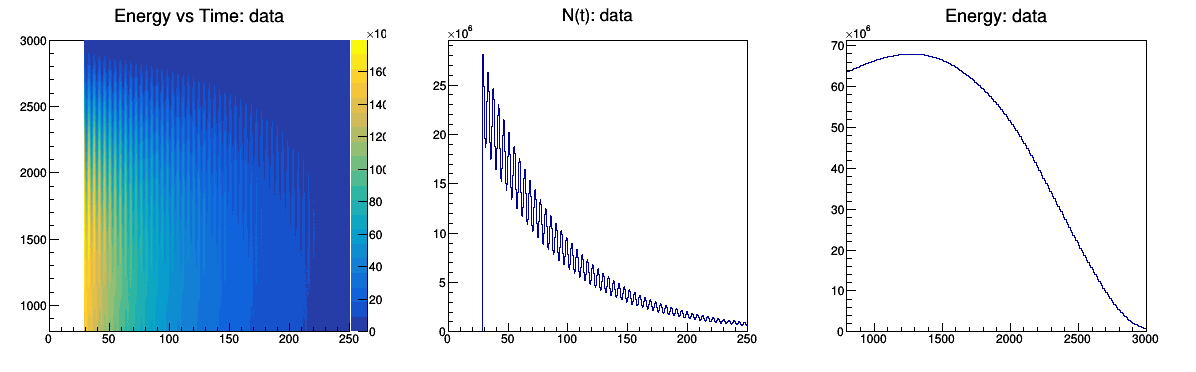

In [4]:
th2d = tfile_bz.Get('all').Clone()

th1d_x,th1d_y = tools.RenderTH2D_ET(th2d,'data')
canvas = R.TCanvas('ETotal','ETotal',1200,400)
canvas.SetTopMargin(0.1)
canvas.Divide(3,1)

canvas.cd(1)
th2d.Draw('COLZ')

canvas.cd(2)
th1d_x.Draw()

canvas.cd(3)
th1d_y.Draw()

canvas.Draw()

In [5]:
hists = []
thresholds = [1300+n*100 for n in range(9)]

for thres in thresholds:
#     print 'threshold={0:.1f}GeV'.format(thres/1000.)
    hist = th2d.ProjectionX('thres%s'%(thres),th2d.GetYaxis().FindBin(thres),th2d.GetYaxis().FindBin(3000))
    hist.SetTitle('threshold={0:.1f}GeV'.format(thres/1000.))
    hists.append(hist.Clone())




In [6]:
#n0 * e^(-t/tau) * (1+A * cos(w * t+phi))
f_wiggle = R.TF1('f1','[0]*exp(-x/[1])*(1+[2]*cos([3]*x+[4]))',30,250)
f_wiggle.SetParameters(3.5e+6,60,1,1.44,0)


 FCN=4.38054e+06 FROM MIGRAD    STATUS=CONVERGED     277 CALLS         278 TOTAL
                     EDM=1.6223e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.47976e+07   6.05693e+02  -4.36404e+00  -6.97933e-07
   2  p1           6.46561e+01   1.02675e-03   1.13121e-05  -3.59730e-01
   3  p2           2.73857e-01   1.68098e-05  -2.82450e-07   3.97550e+01
   4  p3           1.43941e+00   1.26729e-06  -1.86992e-09  -4.75130e+02
   5  p4           2.16380e+00   1.26972e-04   1.34590e-06  -5.62591e+00
 FCN=4.00264e+06 FROM MIGRAD    STATUS=CONVERGED     126 CALLS         127 TOTAL
                     EDM=6.50719e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 


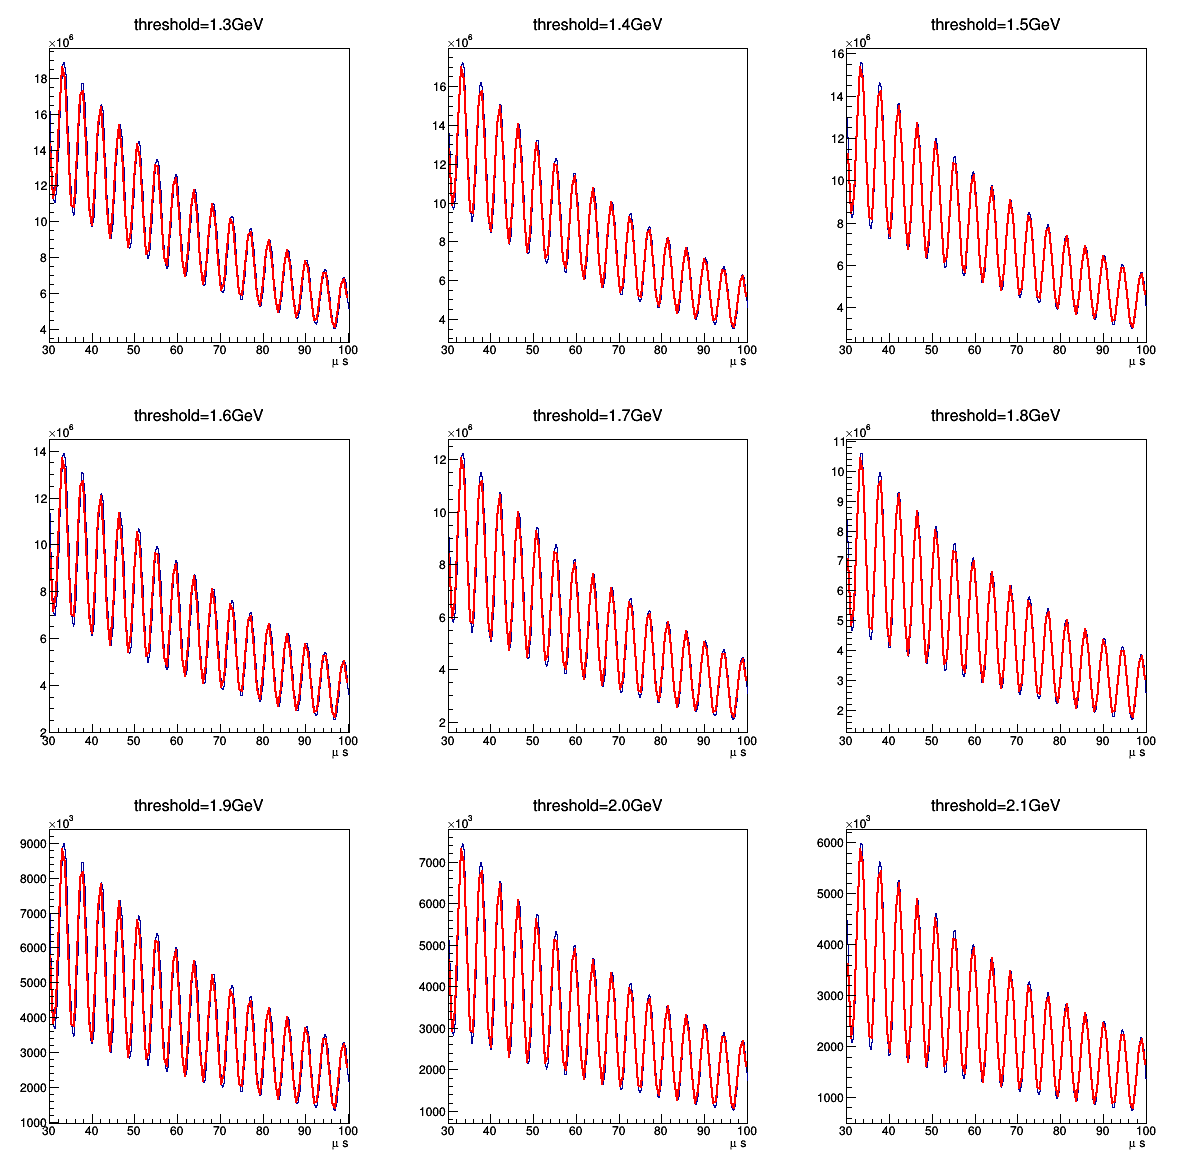

In [7]:
# wiggle with specified positron energy cuts
canvas = R.TCanvas('EThres','EThres',1200,1200)
canvas.SetTopMargin(0.1)
canvas.Divide(3,3)
deltaWs = []
for n in range(9):
    canvas.cd(n+1)
    fit = hists[n].Fit(f_wiggle,'S')
    dw = fit.ParError(3)
    deltaWs.append(dw)
    hists[n].GetXaxis().SetTitle(' #mu s')
    hists[n].Draw()
    hists[n].GetXaxis().SetRangeUser(30.,100)
#     hists[n].Draw()
    hists[n].SetStats(0)
canvas.Draw()

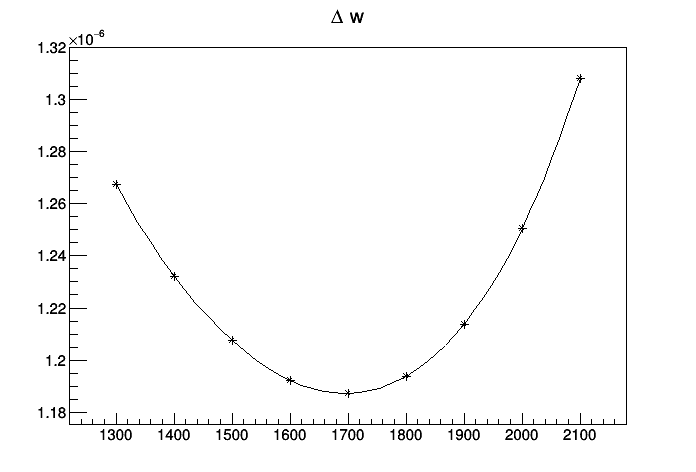

In [7]:
graph = R.TGraph(len(deltaWs),array('d',thresholds),array('d',deltaWs))
c = R.TCanvas()
graph.SetTitle('#Delta w')
graph.Draw('AC*')
c.Draw()


This Best fit value for 1.7 thresholds


```
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.49539e+07   4.71793e+02  -2.51650e+00  -1.89514e-07
   2  p1           6.46359e+01   1.32531e-03   1.05566e-05  -2.56565e-01
   3  p2           3.72741e-01   2.11136e-05  -2.89945e-07   1.08585e+01
   4  p3           1.43940e+00   1.18720e-06  -6.52740e-10   6.11550e+02
   5  p4           2.16521e+00   1.18758e-04  -1.37423e-06   6.29431e+00
 FCN=2.4588e+06 FROM MIGRAD    STATUS=CONVERGED     138 CALLS         139 TOTAL
                     EDM=1.30857e-12    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   0.4 per cent
```

The w = 1.43940, T = 2*Pi/w = 4.365
phase = 2*Pi*t%T/T
phase bin width = 2*Pi*DeltaT/T = 2Pi*0.1492/4.365

In [28]:
#p0 * e^(-t/p1) * (1+p2 * cos(p3 * t+p4))
f_wiggle.SetParameters(1.49539e+07,6.46359e+01, 3.72741e-01,1.43940e+00,2.16521e+00)
Pi = 3.141592653
w = 1.43940e+00
phi = 2.16521e+00

In [29]:
Pi = 3.141592653
w = 1.43940e+00
phi = 2.16521e+00

In [2]:
# The w = 1.43940, T = 2*Pi/w = 4.365
# phase = 2*Pi*(t%T)/T
# phase bin width = 2*Pi*DeltaT/T = 2*Pi*0.1492/4.365
# bin number = 4.365/0.1492 = 29.25
# the phase map x range from 0 to 30 * binWidth
class PhaseMapper:
    def __init__(self,oldTH2):
        self.NX = oldTH2.GetNbinsX()
        self.NY = oldTH2.GetNbinsY()
        self.stepX = oldTH2.GetXaxis().GetBinWidth(1)
        self.stepY = oldTH2.GetYaxis().GetBinWidth(1)
        self.oldTH2 = oldTH2

        self.Pi = 3.141592653
        self.T = 4.365

    def GetNewH(self):
        newStepX = 2*self.Pi*0.1492/self.T
        self.newXmax = 30*newStepX
        h = R.TH2D('PhaseE','Phase map: phase vs energy',
                   30,0.,self.newXmax,
                   self.NY,0,self.NY*self.stepY)
        return h

    def ReMap(self):
        newTH2 = self.GetNewH()
        T = 4.365
        w = 1.43940e-3
        phi = 3.11822e+00
        integral = 0.
        for nx in range(self.NX):
            for ny in range(self.NY):
                value = self.oldTH2.GetBinContent(nx+1,ny+1)
                if value == 0.:
                    continue               
                integral += value
                x_old = (nx+0.5)*self.stepX
                x_new = (w*x_old + phi)%(2*self.Pi)
                
                nx_new = newTH2.GetXaxis().FindBin(x_new)
                newTH2.Fill(x_new,(ny+0.5)*self.stepY,value)
#                 newTH2.SetBinContent(nx_new,ny+1,value_new)
        print integral
        print self.oldTH2.Integral()
        print newTH2.Integral()
        
        return newTH2

In [16]:

# th2Phase = PhaseMapper(tfile_data.Get('Data_TE').Clone()).ReMap()
tfile_data =  R.TFile('output/hists_output_data_v2.root')
th2Data = tfile_data.Get('Data_TE').Clone()
th2OMD = tfile_data.Get('OMD_TE').Clone()
th2RMD = tfile_data.Get('RMD_TE').Clone()

th2Phase = PhaseMapper(th2Data).ReMap()

474569.0
474569.0
474569.0


474569.0
474569.0


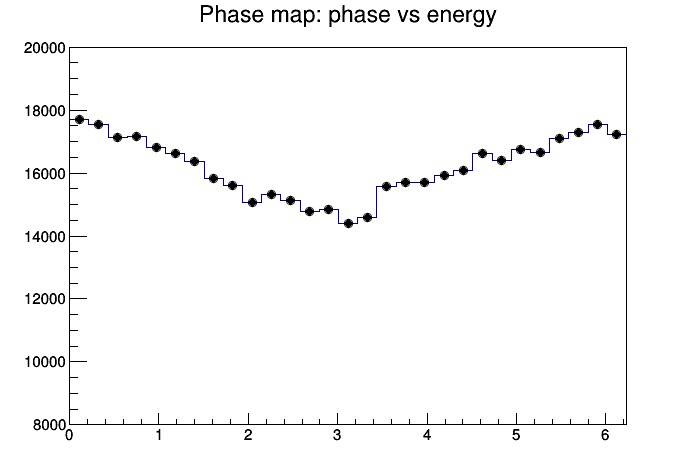

In [64]:
c = R.TCanvas()
# th2Phase.GetYaxis().SetRangeUser(500,3000)
# th2Data.GetXaxis().SetRangeUser(0,10000000)
# th2Phase.RebinY(2)
# th2Phase.GetYaxis().SetRangeUser(0,3000)
# th2Phase.RebinX(8)
th2Phase.SetStats(0)
# th2Phase.Draw('COLZ')
# th2Data.Draw('COLZ')
EP = th2Phase.ProjectionX()
EP.SetStats(0)
EP.SetMarkerSize(1)
EP.SetMarkerStyle(8)
EP.GetXaxis().SetRangeUser(0,6.2)
EP.GetYaxis().SetRangeUser(8000,20000)
# R.gStyle.SetErrorX(0)

EP.Draw('hist ph')
c.Draw()
print tfile_data.Get('Data_TE').Integral()
print th2Phase.Integral()

In [88]:
def getProjectMean(th2):    
    th2 = th2.Clone()
    Nx = th2.GetNbinsX()
    Ny = th2.GetNbinsY()
    StartY = th2.GetYaxis().FindBin(200)
    newH = th2.ProjectionX()
    newH.Reset()

    for nx in range(Nx):
        tot = 0.
        sums = 0.
        for ny in range(StartY,Ny):
            value = th2.GetBinContent(nx+1,ny+1)
            y = th2.GetYaxis().GetBinCenter(ny+1)
            tot += value
            sums += value*y
        mean = sums/tot
        newH.SetBinContent(nx+1,mean)
        print nx+1,mean
    return newH

1 1284.8030086
2 1279.98020528
3 1267.7409997
4 1262.06407956
5 1239.4586301
6 1235.63678884
7 1198.75140112
8 1174.44141346
9 1145.71180849
10 1126.81590949
11 1102.30059213
12 1089.16309013
13 1084.46632315
14 1064.41938757
15 1044.35285341
16 1054.4955073
17 1070.6544029
18 1078.90231274
19 1100.25814985
20 1135.57033438
21 1148.35403982
22 1173.0451664
23 1193.65408855
24 1232.6199332
25 1227.98493193
26 1273.81701807
27 1280.21101993
28 1291.02592267
29 1294.05969284
30 1299.25298805


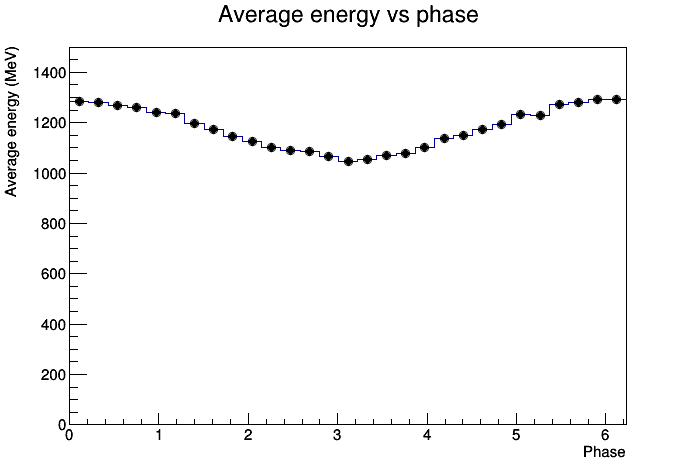

In [95]:
c = R.TCanvas()

EP = getProjectMean( th2Phase)
EP.SetStats(0)
EP.SetMarkerSize(1)
EP.SetMarkerStyle(8)
EP.GetXaxis().SetRangeUser(0,6.2)
EP.GetYaxis().SetRangeUser(0,1500)
EP.GetXaxis().SetTitle('Phase')
EP.GetYaxis().SetTitle('Average energy (MeV)')
EP.SetTitle('Average energy vs phase')
# R.gStyle.SetErrorX(0)
EP.SetMarkerSize(1)
EP.SetMarkerStyle(8)

EP.Draw('hist ph')
c.Draw()

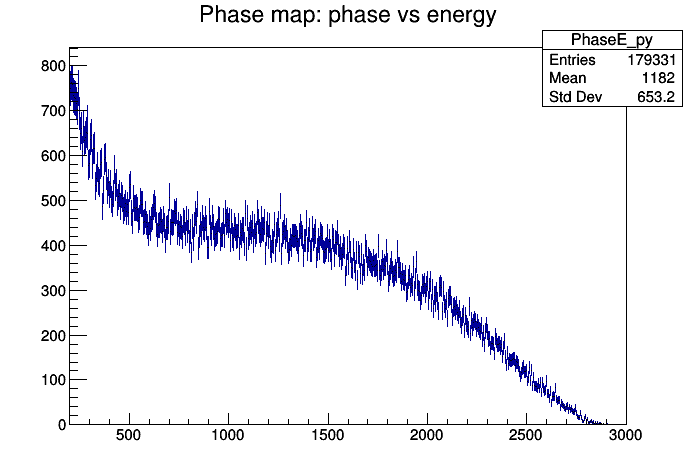

In [87]:
c = R.TCanvas()
# th2Phase.Draw('COLZ')
y = th2Phase.ProjectionY()
y.GetXaxis().SetRangeUser(200,3000)
y.Draw()
c.Draw()

# tfile_data =  R.TFile('output/hists_output_data_v2.root')
th2Phase = PhaseMapper(tfile_data.Get('Data_TE').Clone()).ReMap()

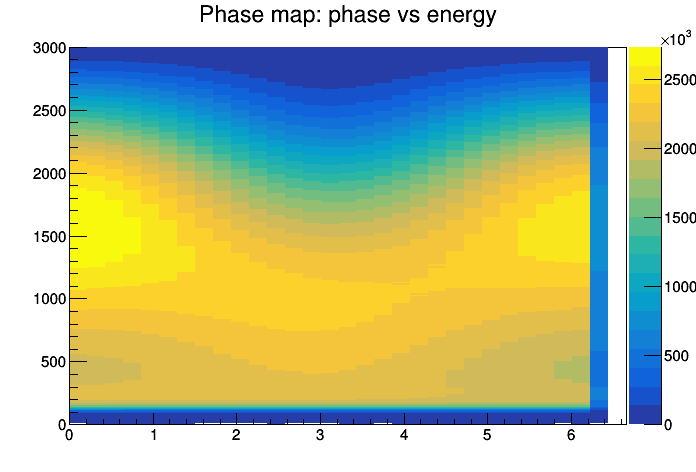

In [11]:
c = R.TCanvas()
th2Phase.GetYaxis().SetRangeUser(0,3000)
th2Phase.GetXaxis().SetRangeUser(0,250)
th2Phase.SetStats(0)
th2Phase.Draw('COLZ')
c.Draw()

In [12]:
# theta = wt+phi
# tfile_bz.Get('all')

Nt = tfile_bz.Get('all').ProjectionX()
print 'here'
n=1
x = 0
for n in range(500):
    content = Nt.GetBinContent(n+1)
    if content!=0:
        x = Nt.GetXaxis().GetBinLowEdge(n+1)
        print 'start from ',n    
        break

theta_min = (1.4394*x + 2.16521)%(2*Pi)
theta_max = (1.4394*(x+0.1492) + 2.16521)%(2*Pi)

#n*Pi = w*t+phi
#t = (n*Pi-phi)/w
for n in range(222,226):
    x = Nt.GetXaxis().GetBinLowEdge(n+1)
    delta = (x*w +phi)%(2*Pi)
    print n,x,min(delta,2*Pi-delta)


here
start from  194
222 33.1224 0.423889888
223 33.2716 0.209131408
224 33.4208 0.005627072
225 33.57 0.220385552


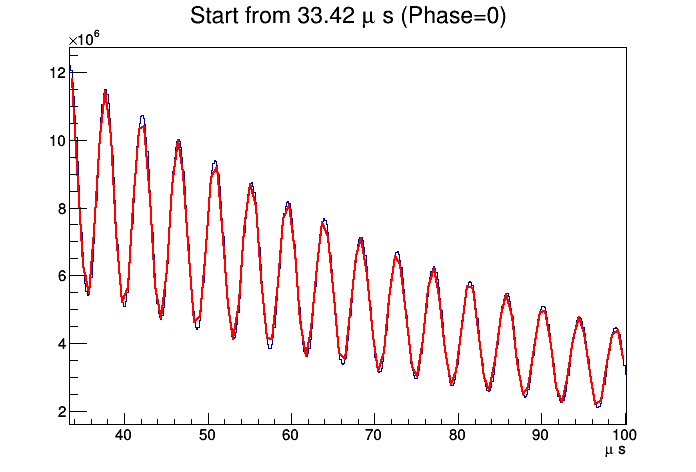

In [13]:

#
c=R.TCanvas()
hists[4].GetXaxis().SetRangeUser(33.4208,100)
hists[4].SetTitle('Start from 33.42 #mu s (Phase=0)')
hists[4].Draw()
c.Draw()



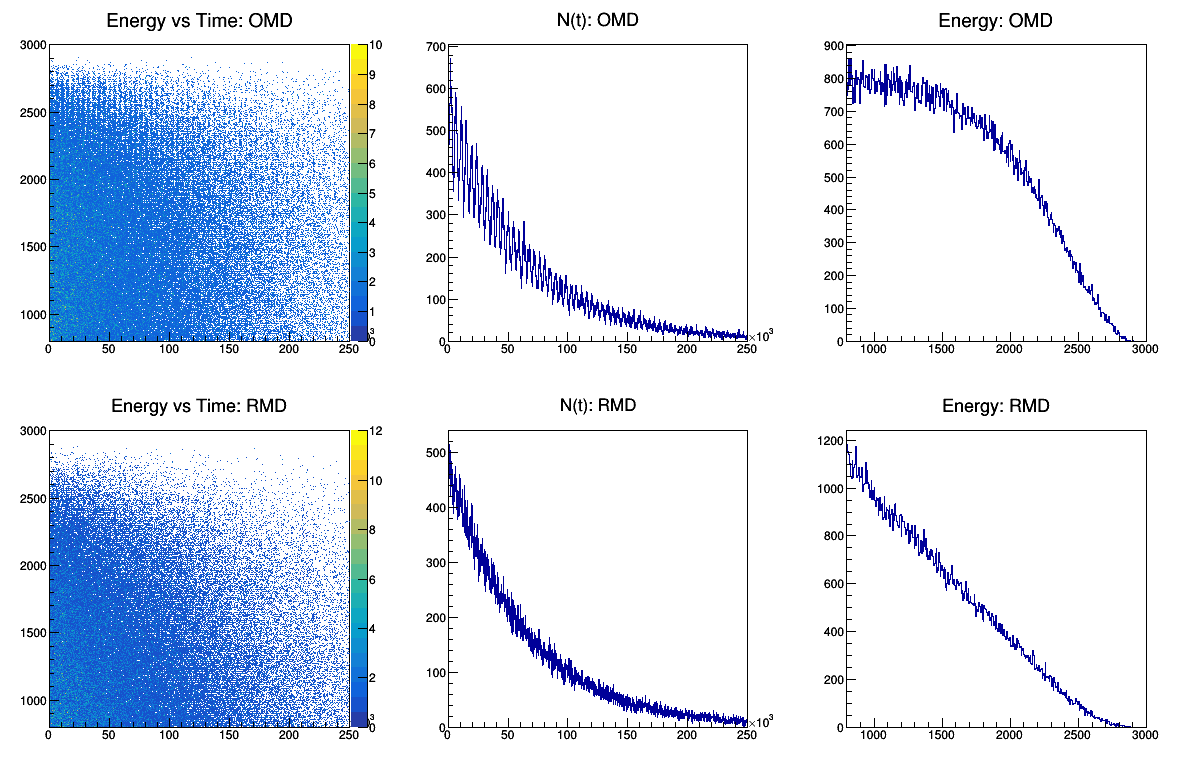

In [14]:
#repeat the works for RMD and OMD
th2d_rmd = tfile_rmd.Get('RMD_TE').Clone()
th1d_rmd_x,th1d_rmd_y = tools.RenderTH2D_ET(th2d_rmd,'RMD')

th2d_omd = tfile_rmd.Get('OMD_TE').Clone()
th1d_omd_x,th1d_omd_y = tools.RenderTH2D_ET(th2d_omd,'OMD')

canvas = R.TCanvas('ETotal','ETotal',1200,800)
canvas.SetTopMargin(0.1)
canvas.Divide(3,2)

canvas.cd(1)
th2d_omd.Draw('COLZ')
canvas.cd(2)
th1d_omd_x.Draw()
canvas.cd(3)
th1d_omd_y.Draw()

canvas.cd(1+3)
th2d_rmd.Draw('COLZ')
canvas.cd(2+3)
th1d_rmd_x.Draw()
canvas.cd(3+3)
th1d_rmd_y.Draw()

canvas.Draw()

threshold=1.7GeV, OMD
threshold=1.7GeV, RMD
 FCN=2267.06 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=4.49537e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.96567e+02   6.84036e-01   1.59046e-02  -2.97473e-04
   2  p1           4.46376e-01   4.49989e-03   1.04631e-04   4.56263e-03
   3  p2           3.12200e+00   1.07951e-02   2.50980e-04   2.00057e-02
 FCN=2635.71 FROM MIGRAD    STATUS=CONVERGED      78 CALLS          79 TOTAL
                     EDM=1.90692e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.18078e+02   5.30241e-01   1.32929e-02  -9.06580e-05
   2  p1           1.32532e-01   6.27072e-03   1.57223e-04  -5

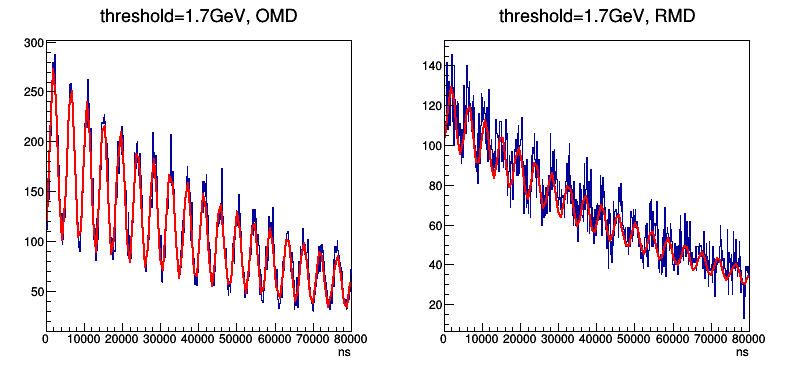

In [27]:
thres = 1700

hist_OMD_Nt = th2d_omd.ProjectionX('Hthres%s'%('OMD'),th2d_omd.GetYaxis().FindBin(thres),th2d_omd.GetYaxis().FindBin(3000))
hist_OMD_Nt.SetTitle('threshold={0:.1f}GeV, OMD'.format(thres/1000.))

hist_RMD_Nt = th2d_rmd.ProjectionX('Hthres%s'%('RMD'),th2d_rmd.GetYaxis().FindBin(thres),th2d_rmd.GetYaxis().FindBin(3000))
hist_RMD_Nt.SetTitle('threshold={0:.1f}GeV, RMD'.format(thres/1000.))

hists = [hist_OMD_Nt,hist_RMD_Nt]

#n0 * e^(-t/tau) * (1+A * cos(w * t+phi))
f_wiggle = R.TF1('f2','[0]*exp(-x/64000.6359)*(1+[1]*cos(0.00143940*x+[2]))',0.,250*1000.)
f_wiggle.SetParameters(60.,0.37,3.14)

#wiggle with specified positron energy cuts
c = R.TCanvas('EThres2','EThres2',800,400)
c.SetTopMargin(0.1)
c.Divide(2,1)

for n in range(2):
    c.cd(n+1)
    print hists[n].GetTitle()
    fit = hists[n].Fit(f_wiggle,'S')
    hists[n].GetXaxis().SetTitle('ns')
    hists[n].Draw()
    hists[n].GetXaxis().SetRangeUser(0.,80.*1000)
    hists[n].SetStats(0)

c.Draw()

threshold=1.7GeV, OMD
threshold=1.7GeV, RMD
 FCN=2267.74 FROM MIGRAD    STATUS=CONVERGED      70 CALLS          71 TOTAL
                     EDM=4.74699e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.62131e+01   4.75961e-01   1.10683e-02  -1.09257e-06
   2  p1           4.56986e-01   6.37583e-03   1.48278e-04   3.10718e-04
   3  p2           3.11573e+00   1.49790e-02   3.48318e-04   2.05069e-03
 FCN=3003.5 FROM MIGRAD    STATUS=CONVERGED      65 CALLS          66 TOTAL
                     EDM=3.73906e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.18243e+02   5.27251e-01   1.41098e-02   1.19226e-03
   2  p1           1.30680e-01   6.22695e-03   1.66685e-04   8.

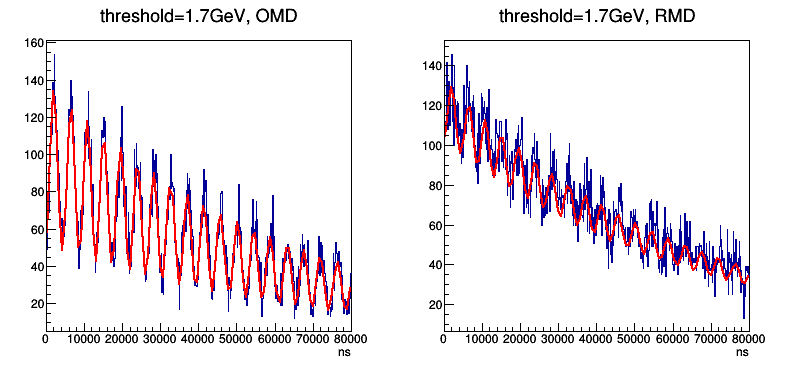

In [23]:
thres = 1700

th2d_omd = tfile_data.Get('OMD_TE')
th2d_rmd = tfile_data.Get('RMD_TE')

hist_OMD_Nt = th2d_omd.ProjectionX('Hthres%s'%('OMD'),th2d_omd.GetYaxis().FindBin(thres),th2d_omd.GetYaxis().FindBin(3000))
hist_OMD_Nt.SetTitle('threshold={0:.1f}GeV, OMD'.format(thres/1000.))

hist_RMD_Nt = th2d_rmd.ProjectionX('Hthres%s'%('RMD'),th2d_rmd.GetYaxis().FindBin(thres),th2d_rmd.GetYaxis().FindBin(3000))
hist_RMD_Nt.SetTitle('threshold={0:.1f}GeV, RMD'.format(thres/1000.))

hists = [hist_OMD_Nt,hist_RMD_Nt]

#n0 * e^(-t/tau) * (1+A * cos(w * t+phi))
f_wiggle = R.TF1('f2','[0]*exp(-x/64000.6359)*(1+[1]*cos(0.00143940*x+[2]))',0.,250*1000.)
f_wiggle.SetParameters(60.,0.37,3.14)

#wiggle with specified positron energy cuts
c = R.TCanvas('EThres2','EThres2',800,400)
c.SetTopMargin(0.1)
c.Divide(2,1)

for n in range(2):
    c.cd(n+1)
    print hists[n].GetTitle()
    fit = hists[n].Fit(f_wiggle,'S')
    hists[n].GetXaxis().SetTitle('ns')
    hists[n].Draw()
    hists[n].GetXaxis().SetRangeUser(0.,80.*1000)
    hists[n].SetStats(0)

c.Draw()

threshold=1.7GeV, Data
 FCN=2535.6 FROM MIGRAD    STATUS=CONVERGED      72 CALLS          73 TOTAL
                     EDM=5.95785e-13    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.97665e+01   4.84662e-01   1.19174e-02   1.69747e-06
   2  p1           4.34580e-01   6.31407e-03   1.55265e-04  -1.04970e-04
   3  p2           3.12241e+00   1.55251e-02   3.81726e-04   1.87480e-05


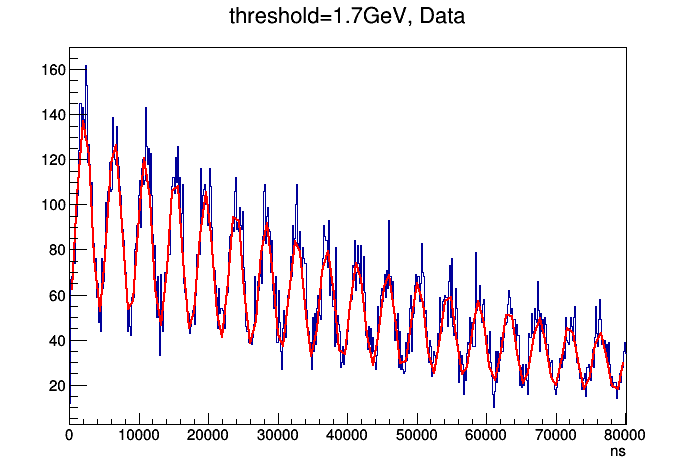

In [24]:
thres = 1700
th2d_data = tfile_data.Get('Data_TE') 
th2d_omd = tfile_data.Get('OMD_TE')
th2d_rmd = tfile_data.Get('RMD_TE')

hist_Data_Nt = th2d_data.ProjectionX('Hthres%s'%('Data'),th2d_data.GetYaxis().FindBin(thres),th2d_data.GetYaxis().FindBin(3000))
hist_Data_Nt.SetTitle('threshold={0:.1f}GeV, Data'.format(thres/1000.))

hist_OMD_Nt = th2d_omd.ProjectionX('Hthres%s'%('OMD'),th2d_omd.GetYaxis().FindBin(thres),th2d_omd.GetYaxis().FindBin(3000))
hist_OMD_Nt.SetTitle('threshold={0:.1f}GeV, OMD'.format(thres/1000.))

hist_RMD_Nt = th2d_rmd.ProjectionX('Hthres%s'%('RMD'),th2d_rmd.GetYaxis().FindBin(thres),th2d_rmd.GetYaxis().FindBin(3000))
hist_RMD_Nt.SetTitle('threshold={0:.1f}GeV, RMD'.format(thres/1000.))

# hists = [hist_OMD_Nt,hist_RMD_Nt]
hists = [hist_Data_Nt]


#n0 * e^(-t/tau) * (1+A * cos(w * t+phi))
f_wiggle = R.TF1('f2','[0]*exp(-x/64000.6359)*(1+[1]*cos(0.00143940*x+[2]))',0.,250*1000.)
f_wiggle.SetParameters(60.,0.37,3.14)

#wiggle with specified positron energy cuts
c = R.TCanvas('EThres3','EThres3')
c.SetTopMargin(0.1)
# c.Divide(2,1)

for n in range(1):
    c.cd(n+1)
    print hists[n].GetTitle()
    fit = hists[n].Fit(f_wiggle,'S')
    hists[n].GetXaxis().SetTitle('ns')
    hists[n].Draw()
    hists[n].GetXaxis().SetRangeUser(0.,80.*1000)
    hists[n].SetStats(0)

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


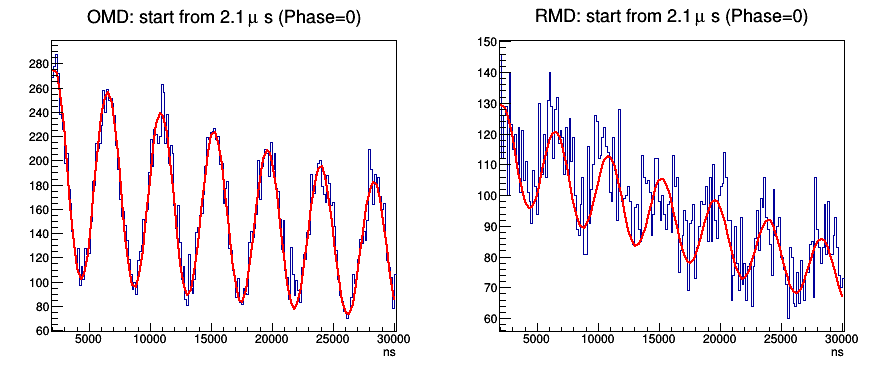

In [33]:
#phi omd = 3.11426
phi = 3.1205
Nt = hists[0]
for n in range(2,5):
    x = Nt.GetXaxis().GetBinLowEdge(n+1)
    delta = (x*w +phi)%(2*Pi)

#     print n,x,min(delta,2*Pi-delta)
#

c=R.TCanvas('c','c',900,400)
c.Divide(2,1)
c.SetTopMargin(0.1)
sample_names = ['OMD','RMD']

for n in range(2):
    c.cd(n+1)
    hists[n].GetXaxis().SetRangeUser(2088,30000) # bin 14
    hists[n].SetTitle('%s: start from 2.1 #mu s (Phase=0)'%(sample_names[n]))
    hists[n].Draw()

# c.cd(2)
# hists[1].GetXaxis().SetRangeUser(2088,30000)
# hists[1].SetTitle('RMD: start from 2.1 #mu s (Phase=0)')
# hists[1].Draw()
c.Draw()

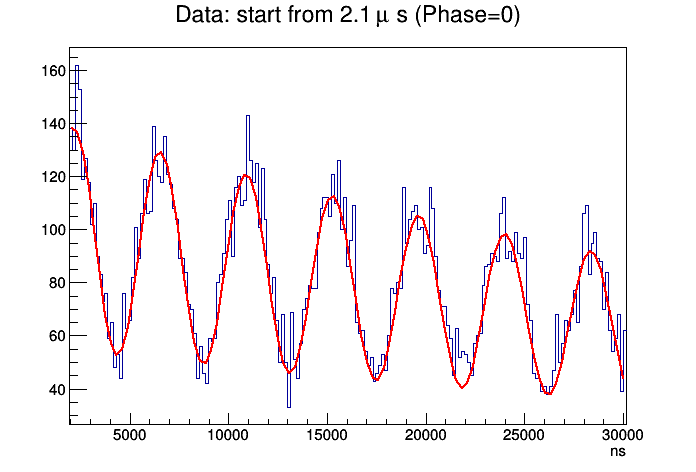

In [25]:
#phi omd = 3.11426
phi = 3.1205
Nt = hists[0]
for n in range(2,5):
    x = Nt.GetXaxis().GetBinLowEdge(n+1)
    delta = (x*w +phi)%(2*Pi)
#     print n,x,min(delta,2*Pi-delta)

#
c=R.TCanvas('c','c')

c.SetTopMargin(0.1)
sample_names = ['Data']
for n in range(1):
    c.cd(n+1)
    hists[n].GetXaxis().SetRangeUser(2088,30000) # bin 14
    hists[n].SetTitle('%s: start from 2.1 #mu s (Phase=0)'%(sample_names[n]))
    hists[n].Draw()
# c.cd(2)
# hists[1].GetXaxis().SetRangeUser(2088,30000)
# hists[1].SetTitle('RMD: start from 2.1 #mu s (Phase=0)')
# hists[1].Draw()
c.Draw()

 
 ```
 TH1F *data;                              //data histogram
  TH1F *mc0;                               // first MC histogram
  TH1F *mc1;                               // second MC histogram
  TH1F *mc2;                               // third MC histogram
  ....                                     // retrieve histograms
   TObjArray *mc = new TObjArray(3);        // MC histograms are put in this array
   mc->Add(mc0);
   mc->Add(mc1);
   mc->Add(mc2);
   TFractionFitter* fit = new TFractionFitter(data, mc); // initialise
   fit->Constrain(1,0.0,1.0);               // constrain fraction 1 to be between 0 and 1
   fit->SetRangeX(1,15);                    // use only the first 15 bins in the fit
   Int_t status = fit->Fit();               // perform the fit
   std::cout << "fit status: " << status << std::endl;
   if (status == 0) {                       // check on fit status
     TH1F* result = (TH1F*) fit->GetPlot();
     data->Draw("Ep");
     result->Draw("same");
   }
```
   

In [37]:
data = tfile_rmd.Get('OMD_nCaloE200') # fake data
mc1 = tfile_rmd.Get('OMD_omd_nCaloE200')
mc2 = tfile_rmd.Get('RMD_nCaloE200')

In [40]:
mc = R.TObjArray(2)
mc.Add(mc1)
mc.Add(mc2)

fitter = R.TFractionFitter(data,mc)
fitter.Fit()

 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 frac0        5.00000e-01  1.00000e-02     no limits
     2 frac1        5.00000e-01  1.00000e-02     no limits
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD        1220        0.01
 **********
 MACHINE ACCURACY LIMITS FURTHER IMPROVEMENT.
 MIGRAD MINIMIZATION HAS CONVERGED.
 FCN=-2.98379e+07 FROM MIGRAD    STATUS=CONVERGED      77 CALLS          78 TOTAL
                     EDM=9.90551e-05    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  frac0        9.95183e-01   4.17530e-03   0.00000e+00  -7.54

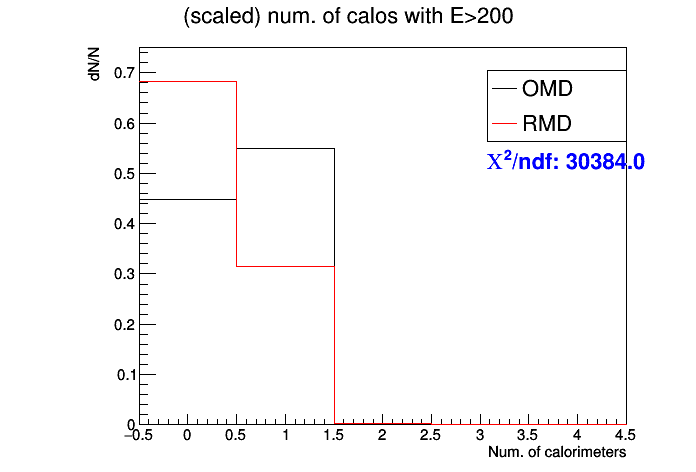

In [41]:
#(scaled) number of calorimeters with E>200

canvas,__t = tools.Draw('BScale',tfile_rmd,'{0:}_nCaloE200','(scaled) num. of calos with E>200','Num. of calorimeters','dN/N',True)
canvas.Draw()